**TASK 1 (BINARY CLASSIFICATION)**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('nn_train.csv')
split = 0.8
s = int((dataset.values.shape[0])*split)
x_data = dataset.values[:s,1:1025]
y_data = dataset.values[:s,1025]
x_cv = dataset.values[s:,1:1025]
y_cv = dataset.values[s:,1025]

dataset = pd.read_csv('nn_test.csv')
x_test = dataset.values[:,1:1025]

In [2]:
"""
#feature scaling method 1
x_data/= x_data.max(axis=0)
print(x_data)
"""

'\n#feature scaling method 1\nx_data/= x_data.max(axis=0)\nprint(x_data)\n'

In [3]:
"""
#feature scaling method 2
x_data = (x_data - np.mean(x_data,axis = 0))/(x_data.max(axis=0)-x_data.min(axis=0))
print(x_data)
"""

'\n#feature scaling method 2\nx_data = (x_data - np.mean(x_data,axis = 0))/(x_data.max(axis=0)-x_data.min(axis=0))\nprint(x_data)\n'

In [4]:
"""

#feature scaling method 3 (Z-Score)
m = np.mean(x_data, axis = 0)
s = np.std(x_data ,axis = 0)
def f_scale3(x,m,s):
    std=s
    x_f=(x - m)/(std+1e-8)
    return x_f
x_data = f_scale3(x_data,m,s)
x_cv = f_scale3(x_cv,m,s)
x_test = f_scale3(x_test,m,s)
print(x_data)

"""

'\n\n#feature scaling method 3 (Z-Score)\nm = np.mean(x_data, axis = 0)\ns = np.std(x_data ,axis = 0)\ndef f_scale3(x,m,s):\n    std=s\n    x_f=(x - m)/(std+1e-8)\n    return x_f\nx_data = f_scale3(x_data,m,s)\nx_cv = f_scale3(x_cv,m,s)\nx_test = f_scale3(x_test,m,s)\nprint(x_data)\n\n'

In [5]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [6]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    return {"W1": W1,"b1": b1,"W2": W2,"b2": b2}

In [8]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b) #"linear_cache" contains (A_prev, W, b)
        A, activation_cache = sigmoid(Z) #"activation_cache" contains "Z"
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b) #"linear_cache" contains (A_prev, W, b)
        A, activation_cache = relu(Z) #"activation_cache" contains "Z"
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [11]:
def L_model_forward(x, parameters):
    caches = []
    A = x
    L = len(parameters) // 2 #no of layers
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,x.shape[1]))
    return AL, caches

In [12]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [13]:
def linear_backward(dZ, cache):
    #cache is "linear_cache" containing (A_prev, W, b) coming from the forward propagation in the current layer
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [21]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [22]:
def L_layer_model(x, Y, layers_dims, learning_rate = 0.0075, num_iterations = 500, print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(x, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

Cost after iteration 0: 0.693351
Cost after iteration 100: 0.691967
Cost after iteration 200: 0.687748
Cost after iteration 300: 0.665371
Cost after iteration 400: 0.643991
Cost after iteration 500: 0.631013
Cost after iteration 600: 0.604902
Cost after iteration 700: 0.746709
Cost after iteration 800: 0.605140
Cost after iteration 900: 0.557316


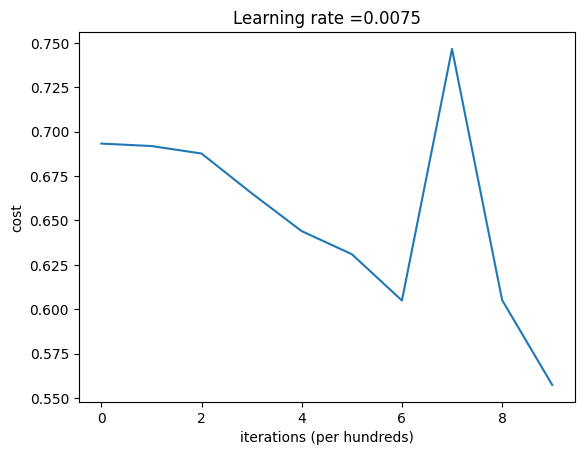

In [23]:
layers_dims = [1024, 128, 64, 32, 1]
y_data = y_data.reshape(-1,1)
x_data=x_data.T
y_data=y_data.T
parameters = L_layer_model(x_data, y_data, layers_dims, num_iterations = 1000, print_cost = True)

In [24]:
y_data.shape

(1, 911)

In [25]:
x_data.shape

(1024, 911)

In [26]:
def predict(x, y, parameters):
    m = x.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    probas, caches = L_model_forward(x, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    return p

In [27]:
pred_train = predict(x_data, y_data, parameters)

Accuracy: 0.7266739846322722


In [28]:
x_cv=x_cv.T
y_cv = y_cv.reshape(-1,1)
y_cv=y_cv.T
pred_test = predict(x_cv, y_cv, parameters)

Accuracy: 0.6271929824561403


In [32]:
def predictt(x, parameters):
    probas, caches = L_model_forward(x,parameters)
    y_preds = (probas>0.5).astype(int)
    return y_preds

In [34]:
x_test = x_test.T
y_test_pred = predictt(x_test, parameters)
print(y_test_pred)

[[1 1 0 ... 0 0 0]]


In [36]:
y_test_pred = y_test_pred.flatten()
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["Predicted"])
y_test_pred_df.to_csv("y_test_pred.csv", index=False)

print("Predictions saved to 'y_test_pred.csv'.")

Predictions saved to 'y_test_pred.csv'.
